In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import quantities as pq
from scipy.optimize import curve_fit
from neo.core import AnalogSignal

In [2]:
def make_sweep(total_time,amplitude,offset_time,tau):
    # Construct x and y without an exponential signal
    sampling_rate = 10000*pq.Hz # samples per ms
    total_samples = (total_time * sampling_rate).simplified
    assert total_samples.dimensionality == pq.dimensionless
    total_samples = int(total_samples)
    noise_sigma = 0.3*pq.mV
    times = np.linspace(0,float(total_time),total_samples)*pq.ms
    vm = AnalogSignal(noise_sigma*np.random.randn(total_samples),
                     times=times,
                     sampling_rate=sampling_rate.rescale(1/pq.ms))

    # Add the exponential signal
    samples_until_offset = (offset_time * sampling_rate).simplified
    assert samples_until_offset.dimensionality == pq.dimensionless
    samples_until_offset = int(samples_until_offset)
    vm[samples_until_offset:] += amplitude*np.exp(-(times[samples_until_offset:]-offset_time)/tau)
    return vm

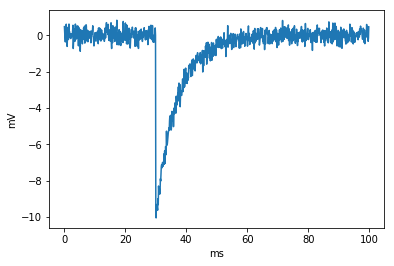

In [3]:
total_time = 100*pq.ms
amplitude = -10*pq.mV
offset_time = 30*pq.ms
tau = 7*pq.ms
    
vm = make_sweep(total_time,amplitude,offset_time,tau)

plt.plot(vm.times.rescale('ms'),vm)
plt.xlabel(pq.ms.symbol)
plt.ylabel(pq.mV.symbol);

In [4]:
class Dummy:
    @classmethod
    def get_segment(cls, vm, start, finish):
        start = int((start/vm.sampling_period).simplified)
        finish = int((finish/vm.sampling_period).simplified)
        return vm[start:finish]
    
    @classmethod
    def get_tau(cls, vm, i):
        start = max(i['delay']-10*pq.ms,i['delay']/2) # 10 ms before pulse start or 
                                                      # halfway between sweep start and pulse start, 
                                                      # whichever is longer
        stop = i['duration']+i['delay']-1*pq.ms # 1 ms before pulse end
        region = cls.get_segment(vm,start,stop)
        amplitude,tau,y0 = cls.exponential_fit(region, i['delay'])
        return tau

    @classmethod
    def exponential_fit(cls, segment, offset):
        t = segment.times.rescale('ms')
        start = t[0]
        offset = offset-start
        t = t-start
        t = t.magnitude
        vm = segment.rescale('mV').magnitude
        offset = (offset * segment.sampling_rate).simplified
        assert offset.dimensionality == pq.dimensionless
        offset = int(offset)
        guesses = [vm.min(), # amplitude (mV)
                   10, # time constant (ms)
                   vm.max()] # y0 (mV)
        vm_fit = vm.copy()
        
        def func(x, a, b, c):
            vm_fit[:offset] = c
            vm_fit[offset:] = a * np.exp(-t[offset:]/b) + c
            return vm_fit
        
        popt, pcov = curve_fit(func, t, vm, p0=guesses) # Estimate starting values for better convergence
        plt.plot(t,vm)
        plt.plot(t,func(t,*popt))
        #print(popt)
        amplitude = popt[0]*pq.mV
        tau = popt[1]*pq.ms
        y0 = popt[2]*pq.mV
        return amplitude,tau,y0

Estimated tau = 6.927 ms; Actual tau = 7.0 ms


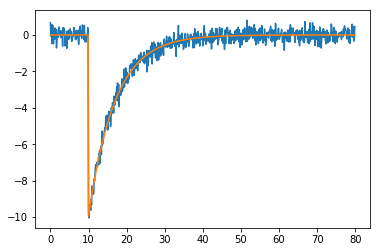

In [5]:
d = Dummy()
i = {'duration':total_time, 'delay':offset_time}
tau_estimated = d.get_tau(vm,i).round(3)
print("Estimated tau = %s; Actual tau = %s" % (tau_estimated,tau))

In [6]:
assert 0.95 < tau_estimated/tau < 1.05